<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_11_Project_3_Option_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Missing Values in Wine Dataset

Take the wine dataset, randomly convert 10 values from residual sugar into NaN values, and then use it to train a model to predict the missing values. Finally, compare the values with the true ones using MSE and especially correlation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import copy

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## High-Quality Figures
from IPython import display
display.set_matplotlib_formats("svg")

In [2]:
# We will use the Wine dataset.
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep = ";")

# Remove the outlier in sulfur dioxide (we know it from previous analysis)
data = data[data["total sulfur dioxide"] < 200]
# remove the quality colum since it is quite subjective and may interfere with the relationship
data = data.drop(["quality"], axis=1)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [3]:
# Normalize all features
data = (data - data.mean())/data.std(ddof=1)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.528185,0.960356,-1.391387,-0.452437,-0.244571,-0.464413,-0.382415,0.556633,1.288066,-0.580034,-0.959006
1,-0.298580,1.965999,-1.391387,0.049005,0.222757,0.876758,0.654456,0.025914,-0.723425,0.127797,-0.583159
2,-0.298580,1.295570,-1.185609,-0.165899,0.095304,-0.081221,0.245992,0.132058,-0.334104,-0.049161,-0.583159
3,1.653061,-1.386143,1.489509,-0.452437,-0.265814,0.110375,0.434514,0.662777,-0.982972,-0.462063,-0.583159
4,-0.528185,0.960356,-1.391387,-0.452437,-0.244571,-0.464413,-0.382415,0.556633,1.288066,-0.580034,-0.959006


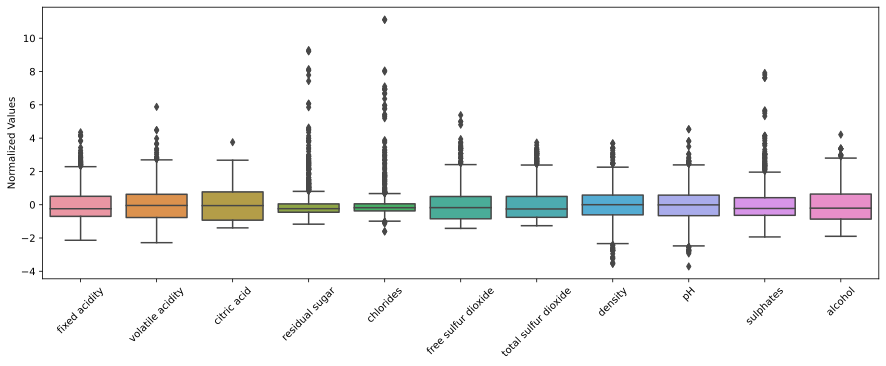

In [4]:
fig, ax = plt.subplots(1, figsize=(15,5))
ax = sns.boxplot(data = data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Normalized Values")
plt.show()

In [5]:
# create a deep copy of the data to modify
original_data = copy.deepcopy(data)
original_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,-0.528185,0.960356,-1.391387,-0.452437,-0.244571,-0.464413,-0.382415,0.556633,1.288066,-0.580034,-0.959006
1,-0.298580,1.965999,-1.391387,0.049005,0.222757,0.876758,0.654456,0.025914,-0.723425,0.127797,-0.583159
2,-0.298580,1.295570,-1.185609,-0.165899,0.095304,-0.081221,0.245992,0.132058,-0.334104,-0.049161,-0.583159
3,1.653061,-1.386143,1.489509,-0.452437,-0.265814,0.110375,0.434514,0.662777,-0.982972,-0.462063,-0.583159
4,-0.528185,0.960356,-1.391387,-0.452437,-0.244571,-0.464413,-0.382415,0.556633,1.288066,-0.580034,-0.959006


In [6]:
data.shape

(1597, 11)

In [7]:
# Introduce Missing Values to the data
nan_vals = 10

# Get 10 random rows to modify
vals2nan = np.random.choice(range(len(data)), size=nan_vals)

# Replace the original values
data["residual sugar"][vals2nan] = np.nan

In [8]:
# Duble check whether it's changed
data.isna().sum()

fixed acidity            0
volatile acidity         0
citric acid              0
residual sugar          10
chlorides                0
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       0
sulphates                0
alcohol                  0
dtype: int64

In [9]:
# Get a vector of all real-valued rows in residual sugar to split the data
loc_nan = np.where(~data["residual sugar"].isna())[0]
print(len(loc_nan))

1587


In [10]:
# Find the exact row number of NaN values
print(np.where(data["residual sugar"].isna())[0])

[   2  570  809  824  899  926  994 1075 1182 1369]


In [11]:
# Split into train and test data: Convert train data and labels into tesnors
cols2keep = data.keys().drop("residual sugar")
train_data = data.dropna()
data_train = torch.tensor(train_data[cols2keep].values).float()
labels_train = torch.tensor(train_data["residual sugar"].values).float()

print(data_train.shape)
print(labels_train)

labels_train = labels_train[:,None]
print(labels_train.shape)

torch.Size([1587, 10])
tensor([-0.4524,  0.0490, -0.4524,  ..., -0.1659, -0.3808,  0.7654])
torch.Size([1587, 1])


In [12]:
# Generate the test dataset and convert into tesnors
test_data = data[data["residual sugar"].isna()]

data_test = torch.tensor(test_data[cols2keep].values).float()
labels_test = torch.tensor(test_data["residual sugar"].values).float()

labels_test = labels_test[:,None]

print(data_test.shape)
print(labels_test.shape)

torch.Size([10, 10])
torch.Size([10, 1])


In [13]:
# Convert to Pytorch datasets
train_data = TensorDataset(data_train, labels_train)
test_data = TensorDataset(data_test, labels_test)

# Translate to dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [14]:
# Build the model architecture
class AnnWine(nn.Module):
    def __init__(self):
        super().__init__()

        # Input layer
        self.input = nn.Linear(10,16)

        # Define two hidden layers
        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,64)

        # Define the output layer
        self.output = nn.Linear(64,1)

    # Forwad Pass
    def forward(self,x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return self.output(x)

In [15]:
numepochs = 200

def trainTheModel():

    net = AnnWine()
    # Loss function and optimizer
    lossfun = nn.MSELoss() # Regression, not classification problem
    optimizer = torch.optim.SGD(net.parameters(), lr = 0.01)

    # Initialize the losses
    trainLoss = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)

    # Loop over the epochs
    for epochi in range(numepochs):

        # switch on he training mode
        net.train()

        # Loop over the training data batches
        batchLoss = []

        for X,y in train_loader:

            # Forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from single batch
            batchLoss.append(loss.item())
            
        # End of the batch loop
        # Average losses accross the baches
        trainLoss[epochi] = np.mean(batchLoss)

    return trainLoss, net

In [16]:
trainLoss, net = trainTheModel()

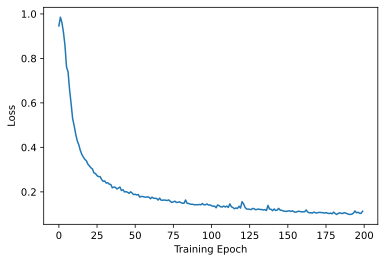

In [17]:
plt.plot(trainLoss)
plt.xlabel("Training Epoch")
plt.ylabel("Loss")
plt.show()

In [18]:
X,y = next(iter(test_loader))
with torch.no_grad():
    yHat = net(X)
yHat

tensor([[-0.1695],
        [ 3.2325],
        [ 0.9975],
        [ 2.5058],
        [ 1.5510],
        [-0.5898],
        [ 0.5802],
        [-0.5459],
        [ 0.0041],
        [ 0.4252]])

In [19]:
real_labels = original_data.iloc[list(vals2nan)]["residual sugar"].sort_index()
real_labels

2      -0.165899
570     0.550447
809     0.192274
824     0.192274
899     0.622082
926    -0.165899
994    -0.022630
1075   -0.380803
1186    3.774003
1373    0.908620
Name: residual sugar, dtype: float64

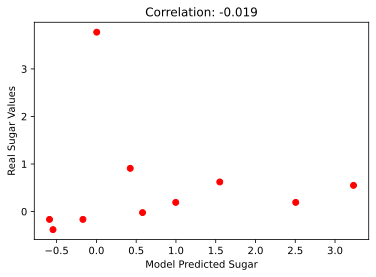

In [20]:
corrTest = np.corrcoef(yHat.detach().T, real_labels.T)[1,0]
plt.plot(yHat.detach(), real_labels, "ro")
plt.xlabel("Model Predicted Sugar")
plt.ylabel("Real Sugar Values")
plt.title(f"Correlation: {corrTest:.3f}")
plt.show()